In [1]:
from cortexlib.rsa import RSA
from cortexlib.utils.file import read_json_file_as_dataframe, write_json_file
from cortexlib.utils.plotting import simclr_colours
from cortexlib.utils.random import set_global_seed
from cortexlib.utils.logging import Logger
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from adjustText import adjust_text
from tqdm.notebook import tqdm
import pandas as pd
import torch
import warnings

logger = Logger()
set_global_seed()

In [2]:
# For each layer, results has an FEV score for predicting neural data from SimCLR features reduced to N PCs
# Load results and filter the best FEV per layer (e.g. feats reduced to optimal number of PCs)
fev_results = read_json_file_as_dataframe('../regressions/results/simclr_feats_pcs_to_neural_data.json')
best_fev_per_layer = fev_results.loc[fev_results.groupby("layer")["mean_fev"].idxmax()]

best_fev_per_layer

,layer,n_pcs,test_r2,mean_fev
37,fc,10.0,0.017885,0.112693
2,layer1,20.0,0.026780,0.127222
9,layer2,NaN,0.030758,0.177962
26,layer3,500.0,0.035916,0.157459
27,layer4,NaN,0.022729,0.112540


In [3]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    simclr_data = torch.load('../regressions/features/simclr_features_all_layers.pt')

simclr_feats = simclr_data['features']

In [4]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    neural_data = torch.load('../regressions/neural_data/neural_responses_mean.pt')

neural_responses_mean = neural_data['neural_responses_mean']

In [5]:
rsa = RSA(neural_data=neural_responses_mean, neural_data_pc_index=0)

pcs_list = [None, 10, 20, 50, 100, 200, 300, 400, 500]
rsa_results = []

logger.progress(f"Computing RSA: SimCLR features vs. PC1 neural data")
for layer, feats in tqdm(simclr_feats.items(), desc="RSA all SimCLR layers"):
    logger.progress(f"SimCLR {layer}")
    feats = feats if feats.dim() <= 2 else feats.view(feats.size(0), -1)
    
    for n_pcs in pcs_list:
        feats_pca = feats if n_pcs is None else PCA(n_pcs).fit_transform(feats)
        sim = rsa.compute_similarity_with_neural_data(feats_pca)
        rsa_results.append({
            'layer': layer,
            'n_pcs': n_pcs,
            'spearman_correlation': sim,
        })

logger.success(f"RSA complete")

15:50:18 | INFO     | ⏳ Computing RSA: SimCLR features vs. PC1 neural data...


RSA all SimCLR layers:   0%|          | 0/5 [00:00<?, ?it/s]

15:50:18 | INFO     | ⏳ SimCLR layer1...
15:52:00 | INFO     | ⏳ SimCLR layer2...
15:52:55 | INFO     | ⏳ SimCLR layer3...
15:53:26 | INFO     | ⏳ SimCLR layer4...
15:53:44 | INFO     | ⏳ SimCLR fc...
15:53:52 | SUCCESS  | ✅ RSA complete!


In [6]:
write_json_file(rsa_results, './results/rsa_simclr_feats_pcs_vs_pc1_neural_data.json')

In [7]:
rsa_results_df = pd.DataFrame(rsa_results)
rsa_results_df.head(12)

,layer,n_pcs,spearman_correlation
0,layer1,NaN,0.163937
1,layer1,10.0,0.098316
2,layer1,20.0,0.100761
3,layer1,50.0,0.103370
4,layer1,100.0,0.098948
5,layer1,200.0,0.093843
6,layer1,300.0,0.091070
7,layer1,400.0,0.089811
8,layer1,500.0,0.089433
9,layer2,NaN,0.165331


In [8]:
# The dimensionality of features varies across model layers, so normalise it by the number of PCs used
rsa_pcs50 = rsa_results_df[rsa_results_df['n_pcs'] == 50].reset_index(drop=True)
rsa_pcs50

,layer,n_pcs,spearman_correlation
0,layer1,50.0,0.103370
1,layer2,50.0,0.125249
2,layer3,50.0,0.121675
3,layer4,50.0,0.081741
4,fc,50.0,0.098825


In [9]:
merged_results = pd.merge(best_fev_per_layer, rsa_pcs50, on='layer')
merged_results

,layer,n_pcs_x,test_r2,mean_fev,n_pcs_y,spearman_correlation
0,fc,10.0,0.017885,0.112693,50.0,0.098825
1,layer1,20.0,0.026780,0.127222,50.0,0.103370
2,layer2,NaN,0.030758,0.177962,50.0,0.125249
3,layer3,500.0,0.035916,0.157459,50.0,0.121675
4,layer4,NaN,0.022729,0.112540,50.0,0.081741


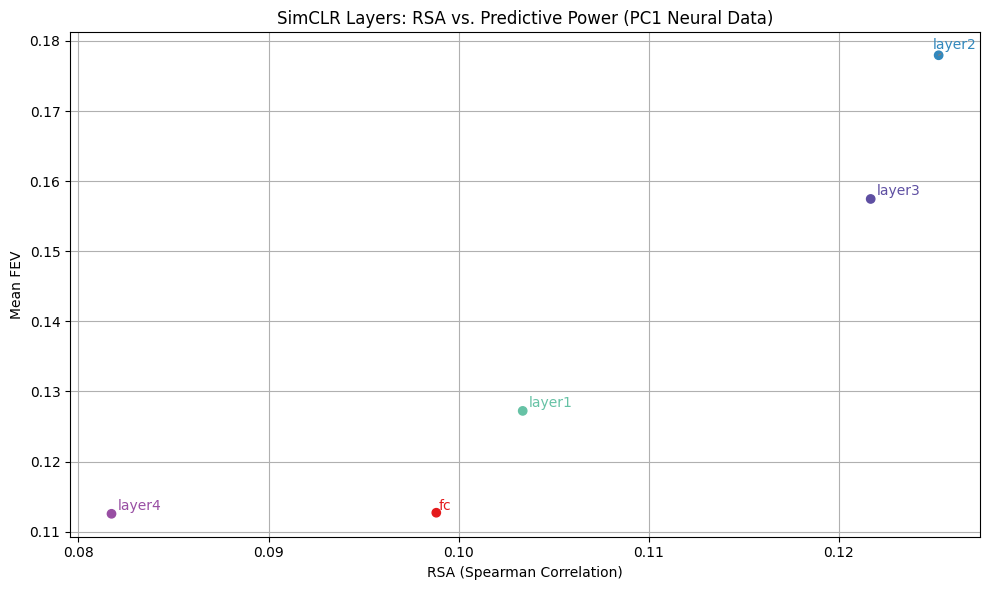

In [10]:
colours = merged_results['layer'].map(simclr_colours)

plt.figure(figsize=(10, 6))
plt.scatter(merged_results['spearman_correlation'], merged_results['mean_fev'], c=colours)

texts = []
for _, row in merged_results.iterrows():
    texts.append(
        plt.text(row['spearman_correlation'], row['mean_fev'], row['layer'],
                 color=simclr_colours[row['layer']], fontsize=10)
    )

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))

plt.xlabel('RSA (Spearman Correlation)')
plt.ylabel('Mean FEV')
plt.title('SimCLR Layers: RSA vs. Predictive Power (PC1 Neural Data)')
plt.grid(True)
plt.tight_layout()
plt.show()